# Evaluate Models
Load a trained model and evaluate it:
- visually
- 

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage

from models.fcn_factory import FcnFactory

#### Load Model and Test Dataset

In [2]:
model_path = 'saved_models/model_20240324_152229_4'
test_ds_path = 'saved_models/test_data/test_ds_20240324_152229'

In [3]:
model_ut = FcnFactory(n_classes=2).make_fcn('resnet50')
model_ut.load_state_dict(torch.load(model_path))
model_ut.eval()
print() # prevent the model being printed, since it is returned from `eval()`

In [4]:
with open(test_ds_path, 'rb') as f:
    test_ds = pickle.load(f)
type(test_ds)

torch.utils.data.dataset.Subset

In [5]:
test_loader = DataLoader(test_ds)
iter_loader = iter(test_loader)

In [6]:
tensor2img = ToPILImage()

In [7]:
example_img, example_mask = next(iter_loader)

In [8]:
example_output = model_ut(example_img)['out']

In [13]:
example_pred = (example_output.detach() > 0.5).float()

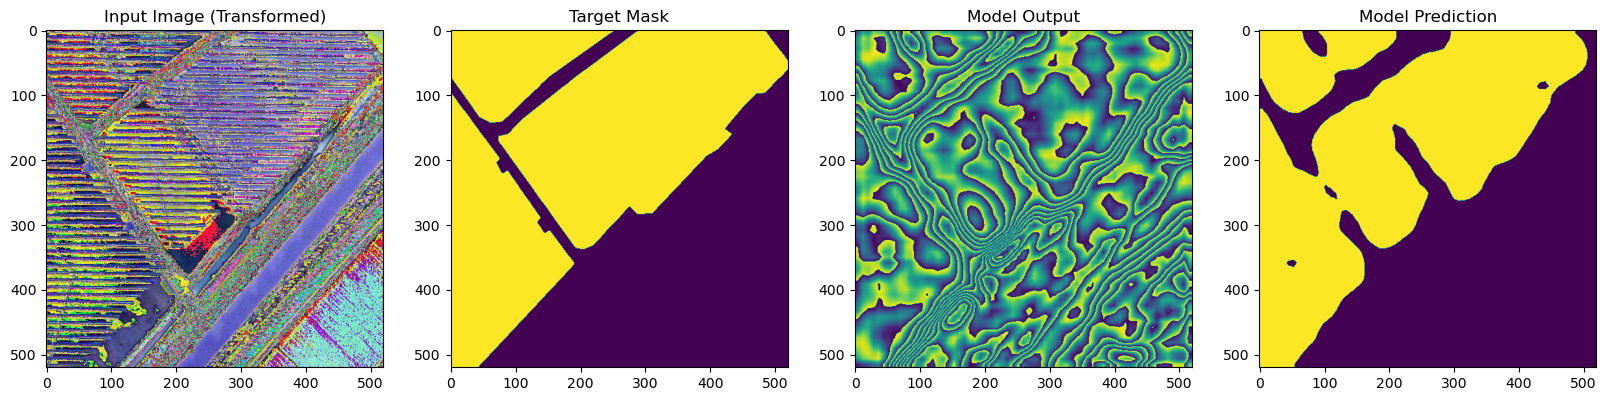

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(tensor2img(example_img[0]))
ax[0].set_title('Input Image (Transformed)')
ax[1].imshow(tensor2img(example_mask[0, 1, :, :]))
ax[1].set_title('Target Mask')
ax[2].imshow(tensor2img(example_output[0, 1, :, :]))
ax[2].set_title('Model Output (Raw)')
ax[3].imshow(tensor2img(example_pred[0, 1, :, :]))
ax[3].set_title('Model Prediction')
plt.show()

In [34]:
def iou(pred: np.array, target: np.array) -> float:
    """Calculate the IoU for a single sample"""
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    return np.sum(intersection) / np.sum(union)


def mean_iou(test_dataset_loader, model) -> float:
    """Calculate the mean IoU for all samples in test dataset"""
    total = 0.
    for input_img, mask in test_dataset_loader:
        prediction = model(input_img)['out']
        prediction = prediction.detach().numpy()
        mask = mask.detach().numpy()
        total += iou(prediction[0, 1], mask[0, 1]) 
    return total / len(test_dataset_loader)

In [35]:
print(f'Mean IoU: {mean_iou(test_loader, model_ut):.2f}')

Mean IoU: 0.2826160239695116
